In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
x = np.linspace(-4, 4, 201).reshape(-1,1)
x = np.concatenate([x, x], 1)
y =[]
for i in range(len(x)):
    y.append( [np.cos(x[i,0])+0.1*x[i,1]**2, np.sin(x[i,1])+x[i,0]**3]   )
y = np.array(y)

idx = np.random.permutation(np.arange(len(x)))
test_ratio=0.2
train_x = x[idx[int(test_ratio*len(x)):]]
train_y = y[idx[int(test_ratio*len(x)):]]
test_x  = x[idx[:int(test_ratio*len(x))]]      
test_y  = y[idx[:int(test_ratio*len(x))]]      
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(161, 2) (161, 2)
(40, 2) (40, 2)


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class IndependentMultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_tasks):

        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_tasks])
        )

        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
        )

        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_tasks]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_tasks])),
            batch_shape=torch.Size([num_tasks])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_tasks, num_latents):
        
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )

        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SVGP:
    def __init__(self, inputs, targets, inducing_num=128):

        self.inputs  = inputs
        self.targets = targets
        
        self.pca = PCA(whiten=True)
        self.sc  = StandardScaler()
        self.pca.fit(inputs)
        self.sc.fit(targets)
        self.inputs  = self.pca.transform(inputs)
        self.targets = self.sc.transform(targets)
        
        inducing_points = torch.from_numpy(self.inputs.astype(np.float32))[:inducing_num, :].unsqueeze(0)
        inducing_points = inducing_points.repeat(targets.shape[1],1,1)
        
        self.model = IndependentMultitaskGPModel(inducing_points, targets.shape[1])
        #self.model = MultitaskGPModel(inducing_points, targets.shape[1], 2)
                
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=targets.shape[1])
        
    def train(self, holdout_ratio=0.1, early_stop=20):
        idx = np.random.permutation(np.arange(len(self.inputs)))
        inputs_t = self.inputs[idx[int(holdout_ratio*len(self.inputs)):]]
        inputs_v = self.inputs[idx[:int(holdout_ratio*len(self.inputs))]]        
        targets_t = self.targets[idx[int(holdout_ratio*len(self.inputs)):]]
        targets_v = self.targets[idx[:int(holdout_ratio*len(self.inputs))]]
        
        dataset_t = TensorDataset(torch.from_numpy(inputs_t.astype(np.float32)), torch.from_numpy(targets_t.astype(np.float32)))
        loader_t  = DataLoader(dataset_t, batch_size=32, shuffle=True, drop_last=True)

        dataset_v = TensorDataset(torch.from_numpy(inputs_v.astype(np.float32)), torch.from_numpy(targets_v.astype(np.float32)))
        loader_v  = DataLoader(dataset_v, batch_size=32, shuffle=True, drop_last=False)
        
        self.model.train()
        self.likelihood.train()        

        optimizer = torch.optim.Adam([{"params":self.model.parameters()},{"params":self.likelihood.parameters()}], lr = 0.01)

        #mll = gpytorch.mlls.VariationalELBO(self.likelihood, self.model, num_data=inputs_t.shape[0])
        mll = gpytorch.mlls.PredictiveLogLikelihood(self.likelihood, self.model, num_data=inputs_t.shape[0])        
        
        cnt=0
        best_valid_loss=1e10
        for i in range(10000):    
            train_loss=[]
            for x_t,y_t in loader_t:
                optimizer.zero_grad() 
                loss = -mll(self.model(x_t), y_t)
                loss.backward() 
                optimizer.step()
                train_loss.append(loss.item())

            valid_loss=[]
            for x_v,y_v in loader_t:
                with torch.no_grad():
                    loss = -mll(self.model(x_v), y_v)
                    valid_loss.append(loss.item())
        
            train_loss=sum(train_loss)/len(train_loss)
            valid_loss=sum(valid_loss)/len(valid_loss)

            if best_valid_loss>valid_loss:
                best_valid_loss=valid_loss
                cnt=0
            else:
                cnt+=1

            if i%10==0:
                print(i,cnt,best_valid_loss,valid_loss)
                
            if cnt>=early_stop:
                break
                
        self.model.eval()
        self.likelihood.eval()                 

    def train2(self, convergence_step=20):

        inputs_t = self.inputs
        targets_t = self.targets
        
        dataset_t = TensorDataset(torch.from_numpy(inputs_t.astype(np.float32)), torch.from_numpy(targets_t.astype(np.float32)))
        loader_t  = DataLoader(dataset_t, batch_size=32, shuffle=True, drop_last=True)
        
        self.model.train()
        self.likelihood.train()        

        optimizer = torch.optim.Adam([{"params":self.model.parameters()},{"params":self.likelihood.parameters()}], lr = 0.01)

        #mll = gpytorch.mlls.VariationalELBO(self.likelihood, self.model, num_data=inputs_t.shape[0])
        mll = gpytorch.mlls.PredictiveLogLikelihood(self.likelihood, self.model, num_data=inputs_t.shape[0])        
        
        cnt=0
        best_train_loss=1e10
        for i in range(10000):    
            train_loss=[]
            for x_t,y_t in loader_t:
                optimizer.zero_grad() 
                loss = -mll(self.model(x_t), y_t)
                loss.backward() 
                optimizer.step()
                train_loss.append(loss.item())
        
            train_loss=sum(train_loss)/len(train_loss)

            if best_train_loss>train_loss:
                best_train_loss=train_loss
                cnt=0
            else:
                cnt+=1

            if i%10==0:
                print(i,cnt,best_train_loss,train_loss)
                
            if cnt>=convergence_step:
                break
                
        self.model.eval()
        self.likelihood.eval()                 
        
        
        
    def predict(self, inputs):
        inputs_pca = self.pca.transform(inputs)
        with torch.no_grad():
            targets_sc = self.model(torch.from_numpy(inputs_pca.astype(np.float32)))
            targets_sc = self.likelihood(targets_sc).to_data_independent_dist()            
        return self.sc.inverse_transform(targets_sc.sample().cpu().numpy())

    def predict_(self, inputs):
        inputs_pca = self.pca.transform(inputs)
        with torch.no_grad():
            targets_sc = self.model(torch.from_numpy(inputs_pca.astype(np.float32)))
            targets_sc = targets_sc.mean         
        return self.sc.inverse_transform(targets_sc.cpu().numpy())

In [4]:
reg = SVGP(x,y)

In [5]:
reg.train2()

0 0 2.934933304786682 2.934933304786682
10 0 2.0972927808761597 2.0972927808761597
20 0 1.5651561816533406 1.5651561816533406
30 0 1.0667434533437092 1.0667434533437092
40 0 0.605315163731575 0.605315163731575
50 0 0.16430110236008963 0.16430110236008963
60 0 -0.23768099149068198 -0.23768099149068198
70 0 -0.5619649688402811 -0.5619649688402811
80 0 -0.9354035953680674 -0.9354035953680674
90 2 -1.0745277404785156 -1.0416007141272228
100 0 -1.325218180815379 -1.325218180815379
110 0 -1.4483772218227386 -1.4483772218227386
120 0 -1.6385957996050518 -1.6385957996050518
130 0 -1.8281680345535278 -1.8281680345535278
140 0 -1.9303073684374492 -1.9303073684374492
150 6 -1.9549478888511658 -1.8079061309496562
160 0 -2.038021961847941 -2.038021961847941
170 2 -2.1443907419840493 -1.9978782534599304
180 1 -2.1606664458910623 -2.136281887690226
190 2 -2.3156733910242715 -2.215532739957174
200 12 -2.3156733910242715 -2.2265260815620422
210 0 -2.38999350865682 -2.38999350865682
220 9 -2.41620786984

In [6]:
test_pred = reg.predict(test_x)

C:\Users\toru.hishinuma\anaconda3\envs\note\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


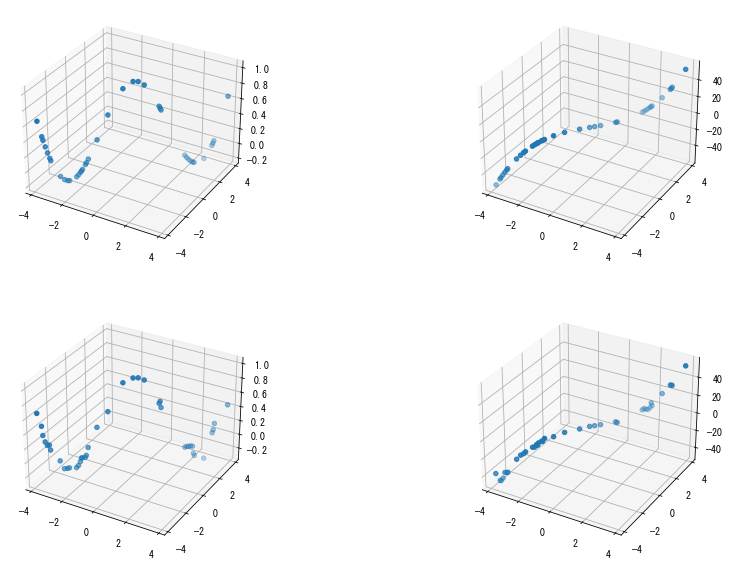

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.rcParams['font.family'] = "MS Gothic"

fig = plt.figure()

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.scatter(test_x[:,0], test_x[:,1], test_y[:,:1])

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.scatter(test_x[:,0], test_x[:,1], test_y[:,1:])

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.scatter(test_x[:,0], test_x[:,1], test_pred[:,:1])

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.scatter(test_x[:,0], test_x[:,1], test_pred[:,1:])